In [ ]:
inpath = ""

A script/jupyter notebook containing the logic to reproduce a colour RGB image of the sample from the detector data

# Demo of Maths Needed for VISR Spectroscopy

In [ ]:
# Dependencies

import h5py
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from numpy.typing import NDArray

In [ ]:
input_hdf5_file_path = Path(inpath)

In [ ]:
def list_file_contents(input_hdf5_file_path: Path) -> None:
    with h5py.File(input_hdf5_file_path) as file:
        # file.visit(print)
        def print_dataset_and_group(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")

        file.visititems(print_dataset_and_group)


list_file_contents(input_hdf5_file_path)

Group: entry
Group: entry/data
Dataset: entry/data/data, shape: (1500, 1216, 1936), dtype: uint8
Group: entry/instrument
Group: entry/instrument/NDAttributes
Dataset: entry/instrument/NDAttributes/BayerPattern, shape: (1500,), dtype: int32
Dataset: entry/instrument/NDAttributes/NDArrayEpicsTSSec, shape: (1500,), dtype: uint32
Dataset: entry/instrument/NDAttributes/NDArrayEpicsTSnSec, shape: (1500,), dtype: uint32
Dataset: entry/instrument/NDAttributes/NDArrayTimeStamp, shape: (1500,), dtype: float64
Dataset: entry/instrument/NDAttributes/NDArrayUniqueId, shape: (1500,), dtype: int32
Dataset: entry/instrument/NDAttributes/RedTotal, shape: (1500,), dtype: int32
Group: entry/instrument/detector
Group: entry/instrument/detector/NDAttributes
Dataset: entry/instrument/detector/NDAttributes/ColorMode, shape: (1500,), dtype: int32
Group: entry/instrument/performance
Dataset: entry/instrument/performance/timestamp, shape: (1500, 5), dtype: float64


In [ ]:
def load_image_from_file(input_hdf5_file_path: Path) -> NDArray[np.uint8]:
    with h5py.File(input_hdf5_file_path) as file:
        images = np.array(file["/entry/data/data"])
    return images


images = load_image_from_file(input_hdf5_file_path)

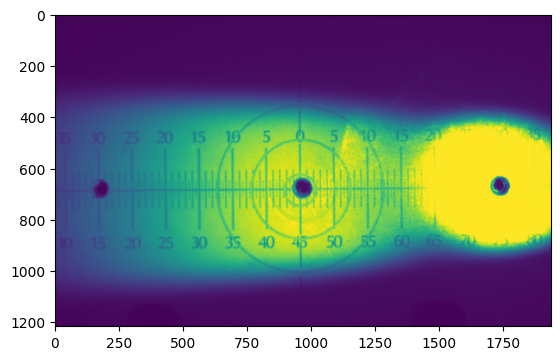

In [ ]:
def plot_full_image(images: NDArray[np.uint8], index: int) -> None:
    plt.imshow(images[index])


plot_full_image(images, 0)

In [ ]:
from dataclasses import dataclass


def load_raw_photo_sensor_rgb_values(input_hdf5_file_path: Path) -> NDArray[np.int32]:
    with h5py.File(input_hdf5_file_path) as file:
        # TODO: update when green and blue is available in the dataset
        red_name = green_name = blue_name = "entry/instrument/NDAttributes/RedTotal"
        dtype = np.int32
        red = np.array(file[red_name], dtype=dtype)
        green = np.array(file[green_name], dtype=dtype)
        blue = np.array(file[blue_name], dtype=dtype)
        if not red.shape == green.shape == blue.shape:
            raise ValueError("invalid input data RBG array shapes don't match")
        rgb = np.vstack((red, green, blue))
        assert rgb.shape == (3, red.shape[0])
        return rgb


raw_rgb_values = load_raw_photo_sensor_rgb_values(input_hdf5_file_path)

In [ ]:
def convert_1d_array_to_2d_grid(
    raw_rgb_values: NDArray[np.int32], grid_shape: tuple[int, int]
) -> NDArray[np.int32]:
    new_shape = (3,) + grid_shape
    return np.reshape(raw_rgb_values, shape=new_shape)


def normalize_rgb_values(raw_rgb_values: NDArray[np.int32]) -> NDArray[np.float64]:
    return raw_rgb_values / float(np.max(raw_rgb_values))


def process_raw_rgb_values(
    raw_rgb_values: NDArray[np.int32], grid_shape: tuple[int, int]
) -> NDArray[np.float64]:
    return normalize_rgb_values(convert_1d_array_to_2d_grid(raw_rgb_values, grid_shape))


# TODO: to be automatically retrieved from the bluesky plan
grid_shape = (30, 50)
rgb_values = process_raw_rgb_values(raw_rgb_values, grid_shape)

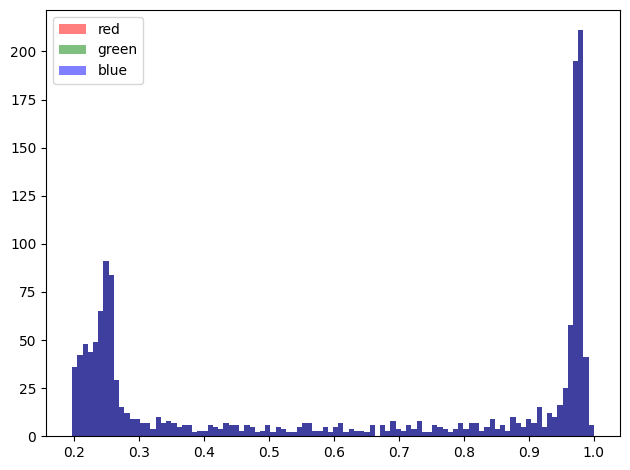

In [ ]:
def plot_histogram_rbg_values(rgb_values: NDArray[np.float64]) -> plt.Figure:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    hist_range = np.min(rgb_values), np.max(rgb_values)
    num_bins = 100
    r = np.ravel(rgb_values[0])
    g = np.ravel(rgb_values[1])
    b = np.ravel(rgb_values[2])
    ax.hist(r, bins=num_bins, range=hist_range, color="red", alpha=0.5, label="red")
    ax.hist(g, bins=num_bins, range=hist_range, color="green", alpha=0.5, label="green")
    ax.hist(b, bins=num_bins, range=hist_range, color="blue", alpha=0.5, label="blue")
    ax.legend()
    fig.tight_layout()
    return fig


_ = plot_histogram_rbg_values(rgb_values)

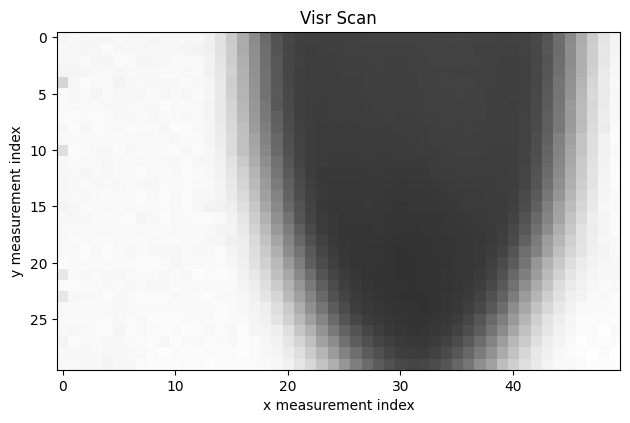

In [ ]:
def plot_rgb_image(rgb_values: NDArray[np.float64]) -> plt.Figure:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rgb_image = np.transpose(rgb_values, (1, 2, 0))
    ax.imshow(rgb_image)
    ax.set_xlabel("x measurement index")
    ax.set_ylabel("y measurement index")
    ax.set_title("Visr Scan")
    fig.tight_layout()
    return fig


_ = plot_rgb_image(rgb_values)

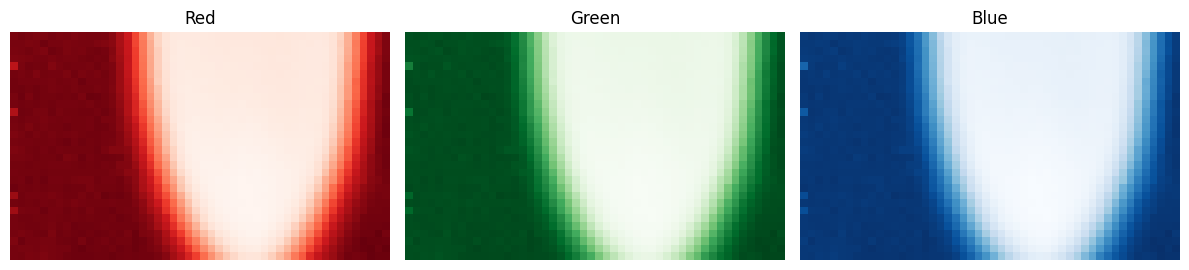

In [ ]:
def plot_rgb_channels(rgb_values: NDArray[np.float64]) -> plt.Figure:
    red = rgb_values[0]
    green = rgb_values[1]
    blue = rgb_values[2]

    # Plot each channel
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(red, cmap="Reds")
    axs[0].set_title("Red")
    axs[0].axis("off")

    axs[1].imshow(green, cmap="Greens")
    axs[1].set_title("Green")
    axs[1].axis("off")

    axs[2].imshow(blue, cmap="Blues")
    axs[2].set_title("Blue")
    axs[2].axis("off")

    fig.tight_layout()
    return fig


_ = plot_rgb_channels(rgb_values)

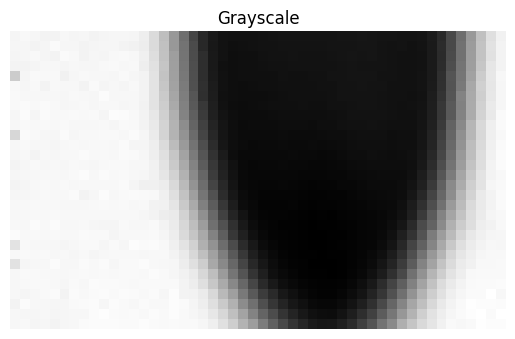

In [ ]:
def plot_grayscale(rgb_values: NDArray[np.float64]) -> plt.Figure:
    grayscale = np.mean(rgb_values, axis=0)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(grayscale, cmap="gray")
    ax.set_title("Grayscale")
    ax.axis("off")
    return fig


_ = plot_grayscale(rgb_values)